## Compute embeddings for terms and audio of the ce game dataset


in this notebook we extract the 150 ce game terms used in the pile sorting experiment and compute embeddings for them based on:
- CLAP language model
- ADA embedding model
- EWE embedding model
- GTE embedding model
- BGE embedding model

In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
                    
import pandas as pd
import scipy
from collections import defaultdict
import copy

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
# helpers
%matplotlib inline

In [10]:
def load_data(group1_fn, group2_fn):
    """
    Load data of the pile sorting experiments
    """
    group1 = pd.read_csv(group1_fn)
    group2 = pd.read_csv(group2_fn)

    # Rename both "Gould" piles
    g1_idx = np.where(group1['Pile'] == 'Gould')[0]
    group1['Pile'][g1_idx] = 'Gould1'

    g2_idx = np.where(group2['Pile'] == 'Gould')[0]
    group2['Pile'][g2_idx] = 'Gould2'

    # Sort results by terms alphabetically
    group1.sort_values(by='Term', inplace=True)
    group2.sort_values(by='Term', inplace=True)

    all_terms = group1['Term']

    pile_names1 = np.unique(group1.Pile)
    pile_names2 = np.unique(group2.Pile)

    pile_names = list(pile_names1) + list(pile_names2)
    pile_names.sort()

    # Create dictionaries of terms per pile
    piles1 = defaultdict(list)
    piles2 = defaultdict(list)

    for term, pile in group1.values:
        piles1[pile].append(term)

    for term, pile, metapile in group2.values:
        piles2[pile].append(term)

    return (group1, group2, all_terms, pile_names,
            pile_names1, pile_names2, piles1, piles2)

### load con espressione game answers

In [11]:
# load data
path = "data/con_espressione_game_answers.csv"
df = pd.read_csv(path)
list_of_w0 = ", ".join(df.answer).split(", ")
list_of_w = [w.strip().lower().replace(",","") for w in list_of_w0 ]
vocab = set(list_of_w)
print("Number of answers: ", len(df))
print("Number of words in the answers: ", len(list_of_w))
print("Number of unique words in the answers: ", len(vocab))

Number of answers:  1462
Number of words in the answers:  3331
Number of unique words in the answers:  1585


In [12]:
# retrieve only relevant columns
df_short = df[["music_id","answer","piece_name","performer"]]
# df_short.head()

In [13]:
# aggregate by piece
aggregation_functions = {'answer': ', '.join, 'performer': max, 'piece_name': max}
df_new = df.groupby(df_short['music_id']).aggregate(aggregation_functions)
df_new.head()

,answer,performer,piece_name
music_id,,,
1,"floating, brisk, romantic, rebellious, fast, m...",Gieseking,bach
2,"mechanic, dancing, simplistic, staccato, mecha...",Gould,bach
3,"shy, magical, deep, delicate, sweet, longing, ...",Grimaud,bach
5,"hasty, nimble, unanimous, fast, mechanical, bo...",Kempff,bach
6,"searching, exploring, traditional, classical, ...",Richter,bach


In [14]:
pieces_list = list(df_new["piece_name"])
pieces_music_id_list = list(df_new.index)
performer_list = list(df_new["performer"])
piece_performer_list = [pieces_list[i]+"_"+performer_list[i] for i in range(len(pieces_list))]

### Load pile information

In [17]:
# Load results from pile sorting experiment

group1_fn = 'data/pile_sorting_group1.csv'
group2_fn = 'data/pile_sorting_group2.csv'

(group1, group2, all_terms, 
 pile_names, _, 
 _, piles1, piles2) = load_data(group1_fn, group2_fn)

In [18]:
# compute pile idx per term
pile_idx_per_term = np.zeros((150, 2), dtype=int)
for i, ((t1, p1), (t2, p2, m2)) in enumerate(zip(group1.values, group2.values)):
    p1i = pile_names.index(p1)
    p2i = pile_names.index(p2)
    pile_idx_per_term[i] = (p1i, p2i)

In [19]:
# use the terms from the pile sorting experiment to constrain the corpus
corpus1 = list(df_new.answer)
#tf_matrix = CountVectorizer( vocabulary=list(df_pile.Term) )
tf_matrix = CountVectorizer( vocabulary=list(all_terms.values))
# transform it to
dtm = tf_matrix.fit_transform(corpus1)
# document term with 45 performances and 150 terms
term_freq = dtm.todense()

### create some helper variables

In [20]:
perf_ids, term_ids, term_frequency = scipy.sparse.find(dtm)

In [21]:
# performances for every term
perf_per_term = defaultdict(list)
# terms for every performance
term_per_perf = defaultdict(list)
terms = list(all_terms.values)

In [22]:
# for every term, store a list of musicid / performance names where the term was used

for term_id, perf_id in zip(term_ids, perf_ids):
    current_term = terms[term_id]
    current_perf = piece_performer_list[perf_id]
    current_music_id = pieces_music_id_list[perf_id]
    
    #perf_per_term[current_term].append([current_music_id, current_perf])
    perf_per_term[current_term].append(current_music_id)
    #term_per_perf[current_perf].append([term_id, current_term])
    term_per_perf[current_perf].append(term_id)

In [23]:
# neighbors in pile 1 per term
neighbors1 = defaultdict(list)
# neighbors in pile 2 per term
neighbors2 = defaultdict(list)

In [24]:
# .. and term and term idx per pile
term_per_pile = defaultdict(list)

for pilename in piles1.keys():
    for term in piles1[pilename]:
        term_idx = terms.index(term)
        #term_per_pile[pilename].append([term_idx, term])
        term_per_pile[pilename].append(term_idx)
        
for pilename in piles2.keys():
    for term in piles2[pilename]:
        term_idx = terms.index(term)
        #term_per_pile[pilename].append([term_idx, term])
        term_per_pile[pilename].append(term_idx)

In [25]:
#import pickle
#with open("data/terms.list", "wb") as fp:   
#    pickle.dump(terms, fp)

### What we have so far

loaded all c.e. game answers and pile sorting piles into convenient data structures.

- term_freq: (45, 150) the occurence of each of the 150 terms in the 45 performances
- dtm = term_freq, but sparse
- piles1: dict of pile 1 (strings, 25), storing terms each (strings)
- piles2: dict of pile 2 (strings, 19), storing terms each (strings)
- piece_performer_list: list of strings of the 45 performances (piece + performer, unique)
- pieces_list: list of strings of the piece names (45, repeats)
- performer_list: list of strings of the performers names (45, repeats)
- pieces_music_id_list: list of music IDs of the 45 performances (note, these are not array idx!)
- terms: list of terms, sorted alphabetically
- pile_names: list of string names of the piles
- term_per_pile: dict of piles (strings, 44, both pile groups), storing term idx each (to index "terms")
- term_per_perf: dict of performance names (strings), storing term idx each (to index "terms")
- pile_idx_per_term: dict of tuples


### Compute a pile and performance based similarity matrix

based on:
- piles: terms used in the same pile increments similarity
- performances: terms used for the same performance increments similarity

In [28]:
term_similarity = np.zeros((len(group1), len(group1))) # 150 x 150

In [29]:
# compute similarity based on piles

for p, terms1 in piles1.items():
    for t in terms1:
        i = np.where(all_terms == t)[0]
        for tt in terms1:
            j = np.where(all_terms == tt)[0]
            term_similarity[i, j] += 1
            
            # abuse this loop to store all the pile neighbors per term
            if tt != t:
                neighbors1[t].append(j[0])
            
for p, terms2 in piles2.items():
    for t in terms2:
        i = np.where(all_terms == t)[0]
        for tt in terms2:
            j = np.where(all_terms == tt)[0]
            term_similarity[i, j] += 1 
            
            # abuse this loop to store all the pile neighbors per term
            if tt != t:
                neighbors2[t].append(j[0])

In [31]:
# update similarity by terms used for same performance
COOCCURENCE_WEIGHT = 0.15

for t in terms:
    
    # index of this term
    i = np.where(all_terms == t)[0]
    print(t, i)
    # index of this term_id in the dtm (= all the positions this term was used)
    # perf_ids, term_ids, term_frequency
    j = np.where(term_ids == i)[0]
    
    # all indices of perf_ids that correspond to the performance where this term was used
    print("performances where this was used", perf_ids[j])
    #k = (perf_ids[j] == perf_ids)
    k = np.any([(l == perf_ids) for l in perf_ids[j]], axis=0)
    print("terms that were co-used", k.sum())
    #print("term_ids that were co-used", term_ids[k])
    local_term_ids = np.unique(term_ids[k])
    print("UNIQUE term_ids that were co-used", len(local_term_ids))
    # loop over all these found idx
    for cooccurence_id in local_term_ids:     
        term_similarity[i[0], cooccurence_id] += COOCCURENCE_WEIGHT 

# normalize
term_similarity /= term_similarity.max()

abrupt [0]
performances where this was used [13 20 44]
terms that were co-used 63
UNIQUE term_ids that were co-used 49
accentuated [1]
performances where this was used [18 27 30 44]
terms that were co-used 83
UNIQUE term_ids that were co-used 58
aggressive [2]
performances where this was used [ 6  9 19 22 26 30 33]
terms that were co-used 133
UNIQUE term_ids that were co-used 70
agitated [3]
performances where this was used [15 20 22 28 31 44]
terms that were co-used 117
UNIQUE term_ids that were co-used 68
airy [4]
performances where this was used [ 2 24 28 36 43]
terms that were co-used 100
UNIQUE term_ids that were co-used 61
amateur [5]
performances where this was used [ 0 22]
terms that were co-used 49
UNIQUE term_ids that were co-used 43
anxious [6]
performances where this was used [ 6 11 19 34]
terms that were co-used 71
UNIQUE term_ids that were co-used 52
authentic [7]
performances where this was used []
terms that were co-used 0
UNIQUE term_ids that were co-used 0
bland [8]
p

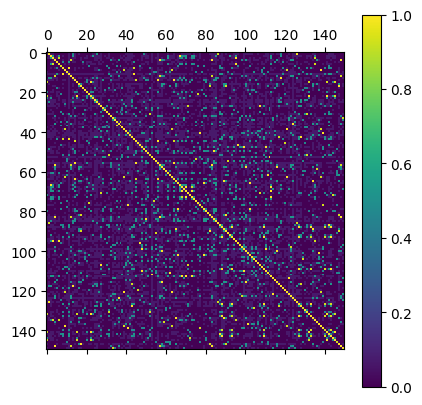

In [32]:
plt.matshow(term_similarity)
plt.colorbar()
plt.show()

In [34]:
term_similarity_only_piles = np.zeros((150,150)) # 150 x 150
# compute similarity based on piles

for p, terms1 in piles1.items():
    for t in terms1:
        i = np.where(all_terms == t)[0]
        for tt in terms1:
            j = np.where(all_terms == tt)[0]
            term_similarity_only_piles[i, j] += 1

for p, terms2 in piles2.items():
    for t in terms2:
        i = np.where(all_terms == t)[0]
        for tt in terms2:
            j = np.where(all_terms == tt)[0]
            term_similarity_only_piles[i, j] += 1 
            
term_similarity_only_piles /= term_similarity_only_piles.max()

In [35]:
term_similarity_only_pile2 = np.zeros((150,150)) # 150 x 150
# compute similarity based on pile 2

for p, terms2 in piles2.items():
    for t in terms2:
        i = np.where(all_terms == t)[0]
        for tt in terms2:
            j = np.where(all_terms == tt)[0]
            term_similarity_only_pile2[i, j] += 1 
            
term_similarity_only_pile2 /= term_similarity_only_pile2.max()

In [36]:
term_similarity_only_pile1 = np.zeros((150,150)) # 150 x 150
# compute similarity based on pile 1

for p, terms1 in piles1.items():
    for t in terms1:
        i = np.where(all_terms == t)[0]
        for tt in terms1:
            j = np.where(all_terms == tt)[0]
            term_similarity_only_pile1[i, j] += 1
            
term_similarity_only_pile1 /= term_similarity_only_pile1.max()

In [37]:
term_similarity_only_performances = np.zeros((150,150)) # 150 x 150
# compute similarity based on performances only

for t in terms:
    # index of this term
    i = np.where(all_terms == t)[0]
    # index of this term_id in the dtm (= all the positions this term was used)
    # perf_ids, term_ids, term_frequency
    j = np.where(term_ids == i)[0]
    # all indices of perf_ids that correspond to the performance where this term was used
    k = np.any([(l == perf_ids) for l in perf_ids[j]], axis=0)
    local_term_ids = np.unique(term_ids[k])
    # loop over all these found idx
    for cooccurence_id in local_term_ids:     
        term_similarity_only_performances[i[0], cooccurence_id] += 0.15 
            
term_similarity_only_performances /= term_similarity_only_performances.max()

In [38]:
PERF_WEIGHT = 1
PILE1_WEIGHT = 1
PILE2_WEIGHT = 1
term_similarity_weighted = PERF_WEIGHT * term_similarity_only_performances + \
                            PILE1_WEIGHT * term_similarity_only_pile1 + \
                            PILE2_WEIGHT * term_similarity_only_pile2
term_similarity_weighted /= term_similarity_weighted.max()

### get embeddings from openAI

we get embeddings for all terms from openai's "text-embedding-ada-002" model

In [39]:
#kk = "USE_YOUR_OWN_KEY"
#import openai
#openai.api_key = kk

In [40]:
#response = openai.Embedding.create(
#        input=terms,
#        model="text-embedding-ada-002")
#embeddings = response['data'][0]['embedding']

In [41]:
#term_embeddings_ada = list()
#for resp in response["data"]:
#    term_embeddings_ada.append(resp['embedding'])

In [42]:
#term_embeddings_ada_npy = np.array(term_embeddings_ada)
#np.save("term_embeddings_ada_npy.npy", term_embeddings_ada_npy, allow_pickle=True, fix_imports=True)

In [43]:
term_embeddings_ada_npy = np.load("data/term_embeddings_ada_npy.npy")

In [44]:
# these embeddings are normalized, so cosine similarity is given by the dot product
similarity_ada = np.dot(term_embeddings_ada_npy, term_embeddings_ada_npy.T)

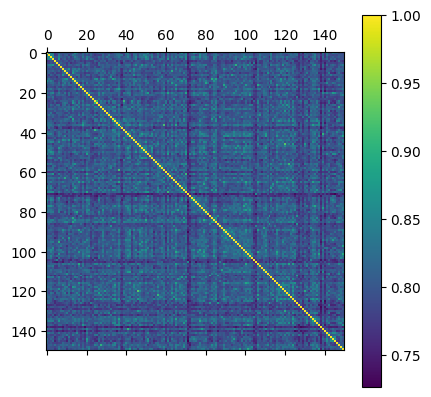

In [45]:
plt.matshow(similarity_ada)
plt.colorbar()
plt.show()

### get embeddings including context from ADA

In [46]:
term_embeddings_ada_context_npy = np.load("data/term_embeddings_ada_context_npy.npy")
similarity_ada_context = np.dot(term_embeddings_ada_context_npy, term_embeddings_ada_context_npy.T)


### get embeddings with and without context from BGE

In [47]:
term_embeddings_bge_npy = np.load("data/term_embeddings_bge_npy.npy")
similarity_bge = np.dot(term_embeddings_bge_npy, term_embeddings_bge_npy.T)
term_embeddings_bge_context_npy = np.load("data/term_embeddings_bge_context_npy.npy")
similarity_bge_context = np.dot(term_embeddings_bge_context_npy, term_embeddings_bge_context_npy.T)


### get embeddings with and without context from GTE

In [48]:
term_embeddings_gte_npy = np.load("data/term_embeddings_gte_npy.npy")
similarity_gte = np.dot(term_embeddings_gte_npy, term_embeddings_gte_npy.T)
term_embeddings_gte_context_npy = np.load("data/term_embeddings_gte_context_npy.npy")
similarity_gte_context = np.dot(term_embeddings_gte_context_npy, term_embeddings_gte_context_npy.T)

In [49]:
similarity_gte_context

array([[0.99999994, 0.9573743 , 0.94951224, ..., 0.94309723, 0.9326481 ,
        0.94532853],
       [0.9573743 , 0.99999994, 0.960732  , ..., 0.9573236 , 0.9345112 ,
        0.9551582 ],
       [0.94951224, 0.960732  , 0.99999994, ..., 0.940041  , 0.92099106,
        0.92967075],
       ...,
       [0.94309723, 0.9573236 , 0.940041  , ..., 1.        , 0.93420416,
        0.95421433],
       [0.9326481 , 0.9345112 , 0.92099106, ..., 0.93420416, 1.        ,
        0.9264462 ],
       [0.94532853, 0.9551582 , 0.92967075, ..., 0.95421433, 0.9264462 ,
        1.0000001 ]], dtype=float32)

### get embeddings from CLAP

we get embeddings for all terms from microsoft's CLAP model

In [50]:
# this code was executed in separate environment using the weights provided by the CLAP developers.

# from CLAPWrapper import CLAPWrapper 

# clap_model = CLAPWrapper(r"PATH_TO_CLAP_weights_2022.pth")

# with open("terms.list", "rb") as fp:   
#     terms = pickle.load(fp)

# text_embeddings = clap_model.get_text_embeddings(terms).numpy()

# np.save("term_embeddings_clap_npy.npy", text_embeddings, allow_pickle=True, fix_imports=True)

In [51]:
term_embeddings_clap_npy = np.load("data/term_embeddings_clap_npy.npy")

In [52]:
# these embeddings are normalized, so cosine similarity is given by the dot product
similarity_clap = np.dot(term_embeddings_clap_npy, term_embeddings_clap_npy.T)

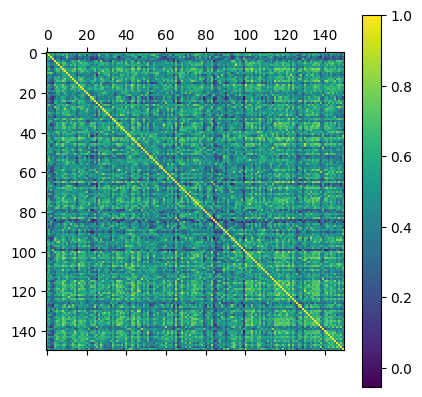

In [53]:
plt.matshow(similarity_clap)
plt.colorbar()
plt.show()

### get embeddings including context from CLAP

In [54]:
# original task
# "Please think of words (if possible, adjectives) that best describe the character of each performance to you"
# prompt = "I listen to a solo piano performance of a classical piece of music and I'd describe the character of the performance as "
# terms_with_context = [prompt + term for term in terms]

# text_embeddings = clap_model.get_text_embeddings(terms_with_context).numpy()
# np.save("term_embeddings_clap_context_npy.npy", text_embeddings, allow_pickle=True, fix_imports=True)

term_embeddings_clap_context_npy = np.load("data/term_embeddings_clap_context_npy.npy")
similarity_clap_context = np.dot(term_embeddings_clap_context_npy, term_embeddings_clap_context_npy.T)


### get audio embeddings from CLAP

audio files are not part of the published dataset due to copyright.

In [55]:
data_audio = np.load("data/audio_embeddings_clap_npy.npz", allow_pickle=True)
# audio CLAP data
audio_embeddings = data_audio["audio_ebeddings"]
file_paths_audio = data_audio["file_paths"]
music_ids_audio = data_audio["music_ids"]

similarity_audio = np.dot(audio_embeddings, audio_embeddings.T)

### get embeddings from EWE

In [56]:
term_embeddings_ewe_npy = np.load("data/term_embeddings_ewe.npy")
similarity_ewe = np.dot(term_embeddings_ewe_npy, term_embeddings_ewe_npy.T)


### dump it all in a nice numpy pickle

extra variables:
- term_similarity (150,150), similarity based on cooccurence in piles and performances
- term_similarity_weighted
- term_similarity_only_performances
- term_similarity_only_piles
- term_similarity_only_pile1
- term_similarity_only_pile2
- term_embeddings_ada_npy (150, 1536), embeddings from openai's ada model
- term_embeddings_ada_context_npy (150, 1024), embeddings from openai's ada model using context prompts
- term_embeddings_clap_npy (150, 1024), embeddings from microsoft's clap model
- term_embeddings_clap_context_npy (150, 1024), embeddings from microsoft's clap model using context prompts
- term_embeddings_bge_npy (150, 1024), embeddings from baai's bge model
- term_embeddings_bge_context_npy (150, 1024), embeddings from baai's bge model using context prompts
- term_embeddings_gte_npy (150, 1024), embeddings from damo's gte model
- term_embeddings_gte_context_npy (150, 1024), embeddings from damo's gte model using context prompts
- term_embeddings_ewe_npy (150, 1024), embeddings from the EWE model
- audio_embeddings (45, 1024), audio embeddings from microsoft's clap model
- file_paths_audio, list of file paths corresponding to the audio embeddings
- music_ids_audio, list of music ids corresponding to the audio embeddings
- similarity_ada (150,150), cosine similarity of ada embeddings
- similarity_ada_context (150,150), cosine similarity of ada embeddings with context prompts
- similarity_clap (150,150), cosine similarity of clap embeddings
- similarity_clap_context (150,150), cosine similarity of clap embeddings with context prompts
- similarity_audio (150,150), cosine similarity of clap audio embeddings
- similarity_ewe (150,150), cosine similarity of ewe embeddings

In [57]:
np.savez("data/preprocessed_embedding_data_complete.npz", 
             # loaded pile sorting and con espressione game data
             term_freq=term_freq,
             dtm=dtm,
             piles1=piles1,
             piles2=piles2,
             # helpers
             piece_performer_list=piece_performer_list, 
             pieces_list=pieces_list,
             performer_list=performer_list,
             pieces_music_id_list=pieces_music_id_list,
             terms=terms,
             pile_names=pile_names,
             term_per_pile=term_per_pile,
             term_per_perf = term_per_perf,
             pile_idx_per_term=pile_idx_per_term,
             # pile similarities
             term_similarity=term_similarity,
             term_similarity_weighted=term_similarity_weighted,
             term_similarity_only_performances=term_similarity_only_performances,
             term_similarity_only_piles=term_similarity_only_piles,
             term_similarity_only_pile1=term_similarity_only_pile1,
             term_similarity_only_pile2=term_similarity_only_pile2,
             # embeddings
             term_embeddings_ada_npy=term_embeddings_ada_npy,
             term_embeddings_ada_context_npy=term_embeddings_ada_context_npy,
             term_embeddings_bge_npy=term_embeddings_bge_npy,
             term_embeddings_bge_context_npy=term_embeddings_bge_context_npy,
             term_embeddings_gte_npy=term_embeddings_gte_npy,
             term_embeddings_gte_context_npy=term_embeddings_gte_context_npy,
             term_embeddings_clap_npy=term_embeddings_clap_npy,
             term_embeddings_clap_context_npy=term_embeddings_clap_context_npy,
             term_embeddings_ewe_npy=term_embeddings_ewe_npy,
             audio_embeddings=audio_embeddings,
             # embedding helpers
             file_paths_audio=file_paths_audio,
             music_ids_audio=music_ids_audio,
             # similarity matrices
             similarity_ada=similarity_ada,
             similarity_ada_context=similarity_ada_context,
             similarity_gte=similarity_gte,
             similarity_gte_context=similarity_gte_context,
             similarity_bge=similarity_bge,
             similarity_bge_context=similarity_bge_context,
             similarity_clap=similarity_clap,
             similarity_clap_context=similarity_clap_context,
             similarity_audio=similarity_audio,
             similarity_ewe=similarity_ewe
             )